# 🧪 **LakeWise: Stratified Sampling & Format Benchmarking on E-Commerce Data**

## 🧱 Lakehouse Layer Overview: Bronze, Silver, Gold

- 🥉 **Bronze** — Raw data ingested from external sources (Kaggle)
- 🥈 **Silver** — Processed and curated data using stratified and random sampling
- 🥇 **Gold** — Analytics-optimized data in compressed Parquet format


### ⚙️ Install Project Dependencies

In [103]:
!pip install -q kaggle duckdb pyarrow tqdm psutil

### 🔗 Mount Google Drive and Create Lake Folders

In [104]:
from pathlib import Path
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
PROJECT_FOLDER = "/content/drive/MyDrive/LakeWise"

for layer in ["Bronze", "Silver", "Gold"]:
    os.makedirs(f"{PROJECT_FOLDER}/{layer}", exist_ok=True)


Mounted at /content/drive


### 🧾 Project Configuration

In [105]:
from pathlib import Path

CONFIG = {
    "INPUT_CSV": "2019-Oct.csv",
    "CHUNK_SIZE": 100_000,
    "TARGET_SIZE": 740_000,
    "SEED": 42
}

BRONZE_PATH        = Path(f"{PROJECT_FOLDER}/Bronze/{CONFIG['INPUT_CSV']}")
STRATIFIED_CSV     = Path(f"{PROJECT_FOLDER}/Silver/stratified_sample_740K.csv")
STRATIFIED_PARQUET = Path(f"{PROJECT_FOLDER}/Silver/stratified_sample_740K.parquet")
RANDOM_PARQUET     = Path(f"{PROJECT_FOLDER}/Silver/random_sample_740K.parquet")
GOLD_PARQUET       = Path(f"{PROJECT_FOLDER}/Gold/stratified_sample_740K_compressed.parquet")


### 📥 Download E-Commerce Dataset (Bronze Layer)

In [106]:
from google.colab import files

if not BRONZE_PATH.exists():
    print("📥 CSV not found. Uploading Kaggle key and downloading dataset...")
    if not Path("kaggle.json").exists():
        uploaded = files.upload()
    os.makedirs("/root/.kaggle", exist_ok=True)
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store
    !unzip -n ecommerce-behavior-data-from-multi-category-store.zip -d ecommerce_data
    !mv ecommerce_data/2019-Oct.csv "{BRONZE_PATH}"
    print("✅ Dataset moved to Bronze layer.")
else:
    print(f"✅ Dataset already exists at {BRONZE_PATH}")


✅ Dataset already exists at /content/drive/MyDrive/LakeWise/Bronze/2019-Oct.csv


In [107]:
from collections import defaultdict
import pandas as pd
from tqdm import tqdm

def summarize_full_dataset(file_path, chunk_size=100_000):
    print("\n📊 Summary of Complete Dataset (using chunked EDA):")

    total_rows = 0
    missing_sum = defaultdict(int)
    dtypes = {}
    duplicate_rows = 0
    sample_chunk = None
    pbar = tqdm(pd.read_csv(file_path, chunksize=chunk_size), desc="🔍 Processing Chunks", unit="chunk")
    for chunk in pbar:
        total_rows += len(chunk)

        # Keep sample chunk for describe/info
        if sample_chunk is None:
            sample_chunk = chunk.copy()

        # Missing values
        for col in chunk.columns:
            missing_sum[col] += chunk[col].isnull().sum()

        # Duplicates (only within chunk)
        duplicate_rows += chunk.duplicated().sum()

    print(f"🧾 Total Rows: {total_rows:,}")
    print("🧼 Total Missing Values Across Entire File:")
    for col, count in missing_sum.items():
        print(f"  {col:<15}: {count:,}")

    print(f"\n🧼 Duplicates Within Chunks: {duplicate_rows:,} (note: inter-chunk dups not detected)")

    if sample_chunk is not None:
        print("\n🔍 Sample Info:")
        print(sample_chunk.info())
        print("\n🔢 Sample Describe:")
        print(sample_chunk.describe(include='all'))


In [108]:
summarize_full_dataset(BRONZE_PATH, CONFIG['CHUNK_SIZE'])


📊 Summary of Complete Dataset (using chunked EDA):


🔍 Processing Chunks: 425chunk [03:02,  2.33chunk/s]


🧾 Total Rows: 42,448,764
🧼 Total Missing Values Across Entire File:
  event_time     : 0
  event_type     : 0
  product_id     : 0
  category_id    : 0
  category_code  : 13,515,609
  brand          : 6,117,080
  price          : 0
  user_id        : 0
  user_session   : 2

🧼 Duplicates Within Chunks: 30,219 (note: inter-chunk dups not detected)

🔍 Sample Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     100000 non-null  object 
 1   event_type     100000 non-null  object 
 2   product_id     100000 non-null  int64  
 3   category_id    100000 non-null  int64  
 4   category_code  67413 non-null   object 
 5   brand          85607 non-null   object 
 6   price          100000 non-null  float64
 7   user_id        100000 non-null  int64  
 8   user_session   100000 non-null  object 
dtypes: float64(1), int64(3), ob

### 🧠 Define LakeWise Sampling Class

In [109]:
from collections import defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm

class LakeWiseSampler:
    def __init__(self, file_path, chunk_size, seed, enable_clean: bool = True, deduplicate: bool = True):
        self.file_path     = file_path
        self.chunk_size    = chunk_size
        self.seed          = seed
        self.enable_clean  = enable_clean
        self.deduplicate   = deduplicate

    def clean_chunk(self, chunk):
        if not self.enable_clean:
            return chunk
        chunk = chunk.dropna().copy()
        chunk["event_time"]    = pd.to_datetime(chunk["event_time"], errors="coerce")
        chunk["event_type"]    = chunk["event_type"].astype("category")
        chunk["category_code"] = chunk["category_code"].astype("category")
        chunk["brand"]         = chunk["brand"].astype("category")
        return chunk

    def get_event_distribution(self, sample_size=1_000_000):
        event_counts = defaultdict(int)
        total_rows = 0
        for chunk in pd.read_csv(self.file_path, chunksize=self.chunk_size):
            chunk = self.clean_chunk(chunk)
            for evt in chunk['event_type'].values:
                event_counts[evt] += 1
            total_rows += len(chunk)
            if total_rows >= sample_size:
                break
        dist = {k: v / total_rows for k, v in event_counts.items()}
        print("📊 Estimated Event Distribution:")
        for evt, pct in dist.items():
            print(f"{evt:<20}: {pct:.4f}")
        return dist

    def stratified_sample(self, final_size):
        dist = self.get_event_distribution()
        target_counts = {evt: int(p * final_size) for evt, p in dist.items()}
        sampled, collected = {evt: [] for evt in dist}, {evt: 0 for evt in dist}
        total = 0
        np.random.seed(self.seed)
        for chunk in tqdm(pd.read_csv(self.file_path, chunksize=self.chunk_size)):
            chunk = self.clean_chunk(chunk)
            for evt in dist:
                avail = chunk[chunk['event_type'] == evt]
                need  = target_counts[evt] - collected[evt]
                if need > 0:
                    n = min(len(avail), need)
                    sel = avail.sample(n, random_state=self.seed)
                    sampled[evt].append(sel)
                    collected[evt] += n
                    total += n
            if total >= final_size:
                break
        df = pd.concat([pd.concat(v) for v in sampled.values()], ignore_index=True)
        if self.deduplicate:
            df = df.drop_duplicates(ignore_index=True)
        return df.sample(frac=1, random_state=self.seed)

    def random_sample(self, final_size, total_rows=42_448_764):
        chunks = []
        seen = 0
        np.random.seed(self.seed)
        for chunk in tqdm(pd.read_csv(self.file_path, chunksize=self.chunk_size)):
            chunk = self.clean_chunk(chunk)
            seen += len(chunk)
            remain = final_size - sum(len(c) for c in chunks)
            if remain <= 0:
                break
            frac = remain / (total_rows - seen + len(chunk))
            sel = chunk.sample(frac=min(frac, 1.0), random_state=self.seed)
            chunks.append(sel)
        df = pd.concat(chunks, ignore_index=True)
        if self.deduplicate:
            df = df.drop_duplicates(ignore_index=True)
        if len(df) < final_size:
            print(f"⚠️ Only {len(df)} unique rows after dedup. Returning all.")
            return df
        return df.sample(n=final_size, random_state=self.seed)


### 🔄 Generate & Save Stratified Sample (Silver Layer)

In [110]:
sampler = LakeWiseSampler(BRONZE_PATH, CONFIG['CHUNK_SIZE'], CONFIG['SEED'], enable_clean = True)

if not STRATIFIED_PARQUET.exists():
    df_strat = sampler.stratified_sample(CONFIG['TARGET_SIZE'])
    df_strat.to_csv(STRATIFIED_CSV, index=False)
    df_strat.to_parquet(STRATIFIED_PARQUET, index=False)
    print(f"✅ Stratified CSV & Parquet saved to Silver layer.")
else:
    df_strat = pd.read_parquet(STRATIFIED_PARQUET)


### 🔁 Generate & Save Random Sample (Silver Layer)

In [111]:
if not RANDOM_PARQUET.exists():
    df_rand = sampler.random_sample(CONFIG['TARGET_SIZE'])
    df_rand.to_parquet(RANDOM_PARQUET, index=False)
    print(f"✅ Random Parquet saved to Silver layer.")
else:
    df_rand = pd.read_parquet(RANDOM_PARQUET)

### 🥇 Save Compressed Output to Gold Layer

In [112]:
if not GOLD_PARQUET.exists():
    df_strat.to_parquet(GOLD_PARQUET, compression='snappy', index=False)
    print(f"✅ Compressed Parquet saved to Gold layer.")

### 📊 Compare Event Distributions

In [113]:
def compare_distributions(ref, samp, title):
    print(f"\n🔍 Distribution Comparison: {title}")
    r = ref if isinstance(ref, dict) else ref['event_type'].value_counts(normalize=True).to_dict()
    s = samp['event_type'].value_counts(normalize=True).to_dict()
    for evt in r:
        diff = abs(r[evt] - s.get(evt,0))
        print(f"{evt:<20}: Ref={r[evt]:.4f}, Samp={s.get(evt,0):.4f}, Δ={diff:.4f}")

orig_dist = sampler.get_event_distribution()

📊 Estimated Event Distribution:
view                : 0.9594
purchase            : 0.0201
cart                : 0.0204


#### Stratified vs Original

In [114]:
compare_distributions(orig_dist, df_strat, "Stratified vs Original")


🔍 Distribution Comparison: Stratified vs Original
view                : Ref=0.9594, Samp=0.9600, Δ=0.0005
purchase            : Ref=0.0201, Samp=0.0202, Δ=0.0000
cart                : Ref=0.0204, Samp=0.0199, Δ=0.0005


#### Random vs Original

In [115]:
compare_distributions(orig_dist, df_rand, "Random vs Original")


🔍 Distribution Comparison: Random vs Original
view                : Ref=0.9594, Samp=0.9484, Δ=0.0110
purchase            : Ref=0.0201, Samp=0.0211, Δ=0.0010
cart                : Ref=0.0204, Samp=0.0304, Δ=0.0100


#### Stratified vs Random

In [116]:
compare_distributions(df_rand, df_strat, "Stratified vs Random")


🔍 Distribution Comparison: Stratified vs Random
view                : Ref=0.9484, Samp=0.9600, Δ=0.0115
cart                : Ref=0.0304, Samp=0.0199, Δ=0.0105
purchase            : Ref=0.0211, Samp=0.0202, Δ=0.0010


## 📦 File Size Comparison (Silver & Gold)

In [117]:
def get_file_size_mb(path: Path) -> float:
    return path.stat().st_size / (1024 * 1024)

print("\n📦 File Size Comparison:")
print(f"CSV            : {get_file_size_mb(STRATIFIED_CSV):.2f} MB")
print(f"Parquet        : {get_file_size_mb(STRATIFIED_PARQUET):.2f} MB")
print(f"Parquet+Snappy : {get_file_size_mb(GOLD_PARQUET):.2f} MB")



📦 File Size Comparison:
CSV            : 101.03 MB
Parquet        : 34.44 MB
Parquet+Snappy : 37.25 MB


### ⏱️ Benchmark Read Time (CSV vs Parquet vs Compressed)

In [118]:
import time
from tqdm import tqdm
import numpy as np

def benchmark_read(path, fn, label, trials=50):
    times = []
    for _ in tqdm(range(trials), desc=f"Measuring {label}"):
        start = time.time()
        _ = fn(path)
        times.append(time.time()-start)
    return np.array(times)

In [119]:
csv_times_path        = Path(PROJECT_FOLDER) / "csv_times.npy"
parquet_times_path    = Path(PROJECT_FOLDER) / "parquet_times.npy"
compressed_times_path = Path(PROJECT_FOLDER) / "compressed_times.npy"
run_read_times = False

if not run_read_times or all(p.exists() for p in [csv_times_path, parquet_times_path, compressed_times_path]):
    print("✅ Timing results loaded from Drive")
    csv_times        = np.load(csv_times_path)
    parquet_times    = np.load(parquet_times_path)
    compressed_times = np.load(compressed_times_path)
else:
    print("⚙️ Measuring and saving timing results...")
    csv_times        = benchmark_read(STRATIFIED_CSV, pd.read_csv,       "CSV")
    parquet_times    = benchmark_read(STRATIFIED_PARQUET, pd.read_parquet, "Parquet")
    compressed_times = benchmark_read(GOLD_PARQUET,     pd.read_parquet, "Parquet+Snappy")

    # Persist to Drive
    np.save(csv_times_path,        csv_times)
    np.save(parquet_times_path,    parquet_times)
    np.save(compressed_times_path, compressed_times)
    print("✅ Timing results saved to Drive")


✅ Timing results loaded from Drive


In [120]:
print("\n📈 Read Time Stats (mean ± std in seconds):")
print(f"CSV             : {np.mean(csv_times):.4f} ± {np.std(csv_times):.4f}")
print(f"Parquet         : {np.mean(parquet_times):.4f} ± {np.std(parquet_times):.4f}")
print(f"Parquet+Snappy  : {np.mean(compressed_times):.4f} ± {np.std(compressed_times):.4f}")


📈 Read Time Stats (mean ± std in seconds):
CSV             : 2.3809 ± 0.3930
Parquet         : 0.9190 ± 0.2279
Parquet+Snappy  : 0.9096 ± 0.2288


#### Comparision

In [121]:
print("\n🚀 Relative Speed Improvements:")
print(f"Parquet is ~{100 * (1 - np.mean(parquet_times) / np.mean(csv_times)):.1f}% faster than CSV")
print(f"Parquet+Snappy is ~{100 * (1 - np.mean(compressed_times) / np.mean(csv_times)):.1f}% faster than CSV")


🚀 Relative Speed Improvements:
Parquet is ~61.4% faster than CSV
Parquet+Snappy is ~61.8% faster than CSV


### 📈 Visualize Read Time Distribution (KDE)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


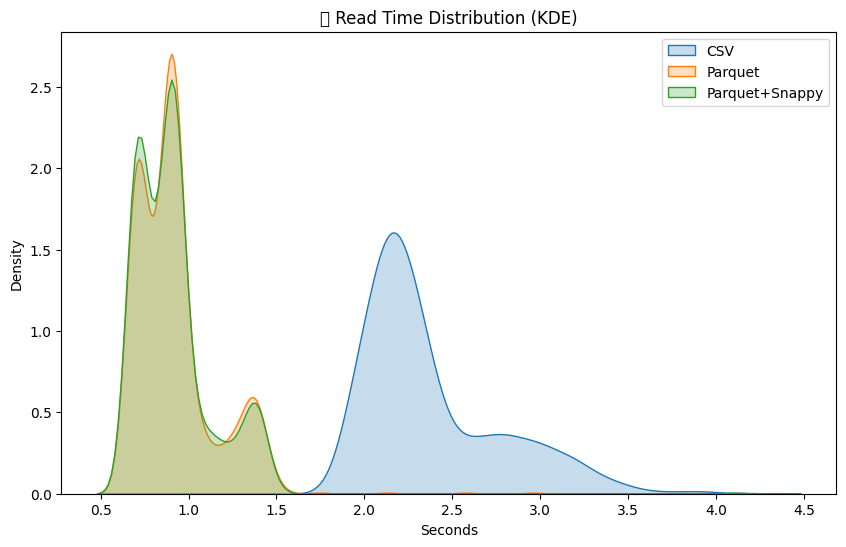

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.kdeplot(csv_times, label="CSV", fill=True)
sns.kdeplot(parquet_times, label="Parquet", fill=True)
sns.kdeplot(compressed_times, label="Parquet+Snappy", fill=True)
plt.title("📊 Read Time Distribution (KDE)")
plt.xlabel("Seconds")
plt.ylabel("Density")
plt.legend()
plt.show()

### 🧠 Memory Usage Snapshot

In [123]:
import psutil
print(f"\n💡 RAM Used: {psutil.Process().memory_info().rss/1024**2:.2f} MB")


💡 RAM Used: 843.69 MB


### EDA

In [124]:
# Load stratified dataset
import pandas as pd

df = pd.read_parquet(STRATIFIED_PARQUET)  # or use STRATIFIED_CSV if preferred

print("🧾 Dataset Info:")
print(df.info())


print("\n🔢 Basic Statistics:")
print(df.describe(include='all'))


🧾 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739551 entries, 0 to 739550
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     739551 non-null  datetime64[ns, UTC]
 1   event_type     739551 non-null  category           
 2   product_id     739551 non-null  int64              
 3   category_id    739551 non-null  int64              
 4   category_code  739551 non-null  object             
 5   brand          739551 non-null  object             
 6   price          739551 non-null  float64            
 7   user_id        739551 non-null  int64              
 8   user_session   739551 non-null  object             
dtypes: category(1), datetime64[ns, UTC](1), float64(1), int64(3), object(3)
memory usage: 45.8+ MB
None

🔢 Basic Statistics:
                                 event_time event_type    product_id  \
count                                739551     7

In [125]:
print("🧼 Missing Values:")
print(df.isnull().sum())

print("\n🧼 Duplicates:")
print(f"Duplicate rows: {df.duplicated().sum()}")


🧼 Missing Values:
event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

🧼 Duplicates:
Duplicate rows: 0


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


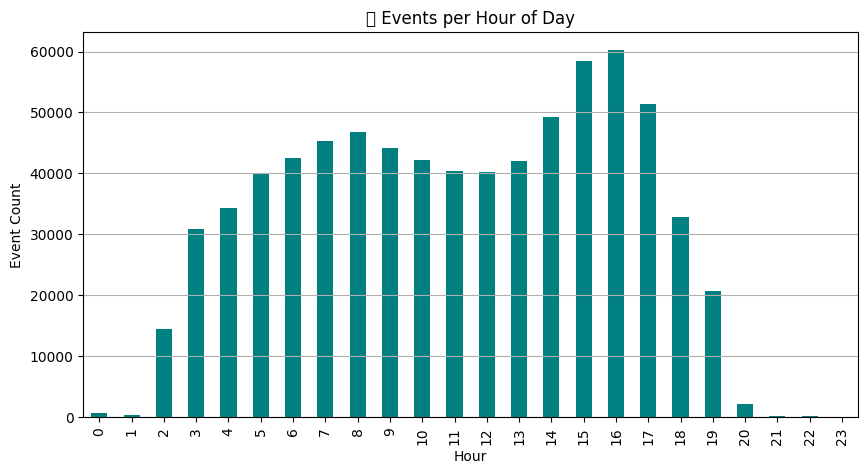

In [126]:
import matplotlib.pyplot as plt

df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')
df['hour'] = df['event_time'].dt.hour

plt.figure(figsize=(10, 5))
df['hour'].value_counts().sort_index().plot(kind='bar', color='teal')
plt.title("🕒 Events per Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Event Count")
plt.grid(axis='y')
plt.show()


/tmp/ipython-input-127-537139872.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='event_type', palette='Set2')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


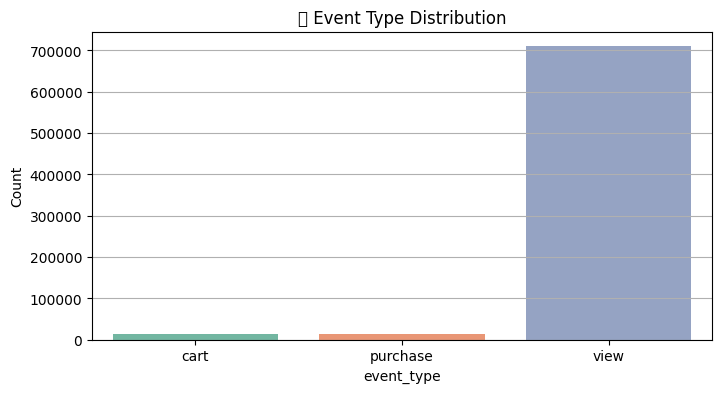

In [127]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='event_type', palette='Set2')
plt.title("📊 Event Type Distribution")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

In [128]:
print("🏷️ Top 10 Category Codes:")
print(df['category_code'].value_counts().head(10))

print("\n🏷️ Top 10 Brands:")
print(df['brand'].value_counts().head(10))

🏷️ Top 10 Category Codes:
category_code
electronics.smartphone              321108
electronics.clocks                   34764
computers.notebook                   33698
electronics.audio.headphone          30911
electronics.video.tv                 25683
appliances.environment.vacuum        19213
appliances.kitchen.washer            18677
appliances.kitchen.refrigerators     16322
apparel.shoes                        14833
computers.desktop                    11435
Name: count, dtype: int64

🏷️ Top 10 Brands:
brand
samsung    136332
apple      120849
xiaomi      69820
huawei      32734
lg          11731
acer        11392
lenovo      10860
oppo        10038
casio        9353
hp           9224
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


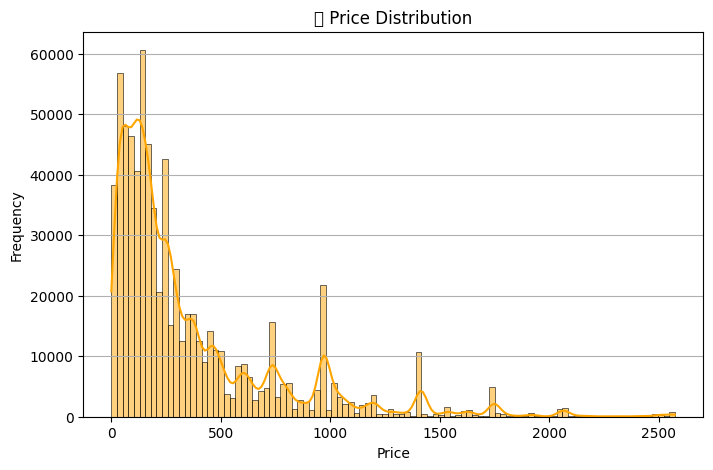

In [129]:
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=100, color='orange', kde=True)
plt.title("💵 Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
# plt.xlim(0, df['price'])  # Trim outliers for visibility
plt.grid(axis='y')
plt.show()


### 🦆 DuckDB Query Time Benchmarking with Predicate Pushdown

In [138]:
import duckdb
import time
import pandas as pd
from pathlib import Path

In [139]:
PARQUET_PATH = STRATIFIED_PARQUET
CSV_PATH     = STRATIFIED_CSV

In [140]:
QUERIES = {
    "Simple Count"     : "SELECT COUNT(*) FROM {}",
    "Price > 1000"     : "SELECT COUNT(*) FROM {} WHERE price > 1000",
    "Only Purchase"    : "SELECT COUNT(*) FROM {} WHERE event_type = 'purchase'",
    "Purchases > ₹1000": "SELECT COUNT(*) FROM {} WHERE event_type = 'purchase' AND price > 1000"
}


In [141]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def run_duckdb_query_stats(path, query, file_type="parquet", runs=1000):
    ext = "read_parquet" if file_type == "parquet" else "read_csv_auto"
    q = query.format(f"{ext}('{path}')")

    times = []
    con = duckdb.connect(database=':memory:')
    for _ in tqdm(range(runs)):
        start = time.time()
        con.execute(q).fetchall()
        times.append(time.time() - start)
    con.close()

    times = np.array(times)
    avg_time = np.mean(times)
    var_time = np.var(times)

    return avg_time, var_time


def benchmark_duckdb_queries(runs=100):
    results = []
    for name, query in QUERIES.items():
        print(f"\n🔎 Benchmarking: {name} ({runs} runs)")

        parquet_avg, parquet_var = run_duckdb_query_stats(PARQUET_PATH, query, file_type="parquet", runs=runs)
        csv_avg, csv_var         = run_duckdb_query_stats(CSV_PATH, query, file_type="csv", runs=runs)

        results.append({
            "Query"          : name,
            "Parquet Avg(s)": round(parquet_avg, 6),
            "Parquet Var"   : round(parquet_var, 8),
            "CSV Avg(s)"    : round(csv_avg, 6),
            "CSV Var"       : round(csv_var, 8),
            "Speedup (x)"   : round(csv_avg / parquet_avg, 2) if parquet_avg > 0 else "∞"
        })
    return pd.DataFrame(results)


In [142]:
benchmark_results = benchmark_duckdb_queries(runs=100)

print("\n🦆 DuckDB Query Benchmark Results:")
print(benchmark_results.to_markdown(index=False))



🔎 Benchmarking: Simple Count (100 runs)


100%|██████████| 100/100 [01:09<00:00,  1.43it/s]



🔎 Benchmarking: Price > 1000 (100 runs)


100%|██████████| 100/100 [01:06<00:00,  1.49it/s]



🔎 Benchmarking: Only Purchase (100 runs)


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]



🔎 Benchmarking: Purchases > ₹1000 (100 runs)


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


🦆 DuckDB Query Benchmark Results:
| Query             |   Parquet Avg(s) |   Parquet Var |   CSV Avg(s) |   CSV Var |   Speedup (x) |
|:------------------|-----------------:|--------------:|-------------:|----------:|--------------:|
| Simple Count      |         0.006705 |    5.23e-06   |     0.697775 | 0.0360341 |        104.06 |
| Price > 1000      |         0.079125 |    0.00575214 |     0.667649 | 0.0250156 |          8.44 |
| Only Purchase     |         0.031432 |    0.00012397 |     0.675518 | 0.0325422 |         21.49 |
| Purchases > ₹1000 |         0.045303 |    0.00030262 |     0.701473 | 0.0292429 |         15.48 |
